In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 43.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import BinaryAccuracy, F1Score, Precision, Recall
from torchmetrics import MeanMetric


In [ ]:
data = pd.read_csv('dataset.csv')

# Data preparation

In [ ]:
# data.reset_index(drop=True, inplace=True)
# data

In [ ]:
# unique speaker in train and test
unique_speakers = data['speaker_id'].unique()
train_speakers, test_speakers = train_test_split(unique_speakers, test_size=0.2, random_state=42)
train_data = data[data['speaker_id'].isin(train_speakers)]
test_data = data[data['speaker_id'].isin(test_speakers)]
assert set(train_data['speaker_id']).isdisjoint(set(test_data['speaker_id'])), "Overlap in train and test speakers!"
print(f"Train data: {len(train_data)} samples, Test data: {len(test_data)} samples")


Train data: 8508 samples, Test data: 2198 samples


In [ ]:
# training and validation split
training_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
print(f"Training data: {len(training_data)} samples, Validation data: {len(val_data)} samples")


Training data: 6806 samples, Validation data: 1702 samples


In [ ]:
# Defining a custom dataset for Siamese network pairs
class DysphoniaPairsDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.embeddings = data['embedding'].apply(lambda x: torch.tensor(eval(x), dtype=torch.float32))  # Assuming embeddings are stored as strings
        self.labels = data['category'].map({'healthy': 0, 'patient': 1})
        self.languages = data['language']
        self.gender = data['gender']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get two random samples, ensure one is similar or dissimilar based on idx parity
        row1 = self.data.iloc[idx]
        label1 = self.labels.iloc[idx]
        language1 = self.languages.iloc[idx]
        gender1 = self.gender.iloc[idx]

        # Create positive or negative pairs
        if idx % 2 == 0:  # Positive pair
            row2 = self.data[(self.labels == label1) & (self.gender == gender1) & (self.languages == language1)].sample(1).iloc[0]
            label = 1
        else:  # Negative pair
            row2 = self.data[self.labels != label1].sample(1).iloc[0]
            label = 0

        # Convert to tensors
        embedding1 = torch.tensor(eval(row1['embedding']), dtype=torch.float32)
        embedding2 = torch.tensor(eval(row2['embedding']), dtype=torch.float32)

        return embedding1, embedding2, torch.tensor(label, dtype=torch.float32)


In [ ]:
# Create DataLoaders for traininin, validation and testing.
train_dataset = DysphoniaPairsDataset(train_data)
val_dataset = DysphoniaPairsDataset(val_data)
test_dataset = DysphoniaPairsDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

SIAMESE NETWORK

# Model Architecture


In [ ]:
#------------------------------------------------------------------------
#            Model Architecture
#------------------------------------------------------------------------

# Define the sub-network for embedding generation
class EmbeddingNet(nn.Module):
    def __init__(self, input_dim, output_dim=192):
        super(EmbeddingNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, stride=1, padding=2),  # 1 input channel, 64 filters
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.3),

            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),  # 64 input channels, 128 filters
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.3),

            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),  # 128 input channels, 256 filters
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.4),

            nn.Conv1d(256, 512, kernel_size=5, stride=1, padding=2), # 256 input channels, 512 filters
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.4)
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Pool to (batch_size, channels, 1)
        self.fc = nn.Linear(512, output_dim)  # Final dense layer to map to output_dim

    def forward(self, x):
        # Input shape: (batch_size, input_dim)
        x = x.unsqueeze(1)  # Reshape to (batch_size, 1, input_dim) for Conv1D
        x = self.conv(x)  # Apply Conv1D layers
        x = self.global_pool(x)  # Global average pooling: (batch_size, channels, 1)
        x = x.squeeze(-1)  # Remove last dimension, shape becomes (batch_size, channels)
        x = self.fc(x)  # Fully connected layer to get the final embedding
        return x

In [ ]:
# saimese network
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = EmbeddingNet(input_dim, embedding_dim)

    def forward(self, input1, input2):
        # Get embeddings for both inputs
        output1 = self.embedding_net(input1)
        output2 = self.embedding_net(input2)
        # Calculate cosine similarity
        similarity = F.cosine_similarity(output1, output2, dim=1)
        return similarity

Updating the loss function

In [ ]:
# loss computation by contrastive loss
class CosineContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(CosineContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, similarity, label):
        # For similar pairs (label == 1), maximize similarity
        # For dissimilar pairs (label == 0), ensure similarity is below margin
        loss = label * (1 - similarity) + (1 - label) * F.relu(similarity - self.margin)
        return loss.mean()

In [ ]:
# Function to implement dynamic cosine similarity threshold
def dynamic_cosine_threshold(similarity, batch_similarity):
    """
    Adjust the threshold based on the batch's similarity score distribution.
    In this case, using the mean of the batch's cosine similarity.
    """
    threshold = batch_similarity.mean().item()  # Dynamic threshold based on mean similarity of the batch
    return (similarity > threshold).float()  # Use dynamic threshold for predictions


In [ ]:
# Set parameters
input_dim = len(eval(data['embedding'].iloc[0]))  # Dimension of embeddings in the CSV
embedding_dim = 192
margin = 0.5
epochs = 200
learning_rate = 0.001
# Initialize model, loss, and optimizer
model = SiameseNetwork(input_dim, embedding_dim)
criterion = CosineContrastiveLoss(margin=margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# Implementing a learning rate scheduler learning rate with plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)



# Metrics and training

In [ ]:
#using cuda instead of cpu for faster computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)


In [ ]:
# Initialize metrics
train_loss_metric = MeanMetric()  # For averaging training loss
val_loss_metric = MeanMetric()  # For averaging validation loss
test_loss_metric = MeanMetric()   # For averaging test loss
accuracy_metric = BinaryAccuracy().to(device)  # For calculating accuracy (binary task)
f1_score_metric = F1Score(task='binary', num_classes=2, average='macro').to(device)  # F1 score metric
precision_metric = Precision(task='binary', num_classes=2, average='macro').to(device)  # Precision metric
recall_metric = Recall(task='binary', num_classes=2, average='macro').to(device)

In [ ]:
# Initialize val_loss to infinity
best_val_loss = float('inf')
start_epoch = 0  # Default start epoch
print("Starting training..... \n")
# Optionally load from checkpoint
resume_training = False  # Set to False if starting fresh
if resume_training:
    checkpoint = torch.load('best_model.pth')

    # Load the model weights from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])

    # If needed, you can also load optimizer state and epoch
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resuming training from epoch {start_epoch} with best validation loss: {best_val_loss:.4f}")

train_losses = [] # for plotting losses
val_losses = [] # plotting

for epoch in range(start_epoch, epochs):
    # Training loop
    model.train()
    train_loss_metric.reset()

    for embedding1, embedding2, label in train_loader:
        embedding1, embedding2, label = embedding1.to(device), embedding2.to(device), label.to(device)
        optimizer.zero_grad()
        similarity = model(embedding1, embedding2)
        loss = criterion(similarity, label)
        loss.backward()
        optimizer.step()
        train_loss_metric.update(loss.item())
    train_loss = train_loss_metric.compute() # updated train loss


    # Validation loop
    model.eval()
    val_loss_metric.reset()
    with torch.no_grad():
        for embedding1, embedding2, label in val_loader:
            embedding1, embedding2, label = embedding1.to(device), embedding2.to(device), label.to(device)
            similarity = model(embedding1, embedding2)
            loss = criterion(similarity, label)
            val_loss_metric.update(loss.item())
    val_loss = val_loss_metric.compute() # updated val loss

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    # Get the updated learning rate
    lr = optimizer.param_groups[0]['lr']
    # Adjust print statement for correct epoch display

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate:{lr:.7f}")

    # Checkpointing: Save model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }
        torch.save(checkpoint, 'best_model.pth')  # Save the checkpoint

print("Training complete.")


Starting training..... 

Epoch 1/200, Training Loss: 0.2361, Validation Loss: 0.2113, Learning Rate:0.0010000
Epoch 2/200, Training Loss: 0.2253, Validation Loss: 0.2256, Learning Rate:0.0010000
Epoch 3/200, Training Loss: 0.2240, Validation Loss: 0.2231, Learning Rate:0.0010000
Epoch 4/200, Training Loss: 0.2200, Validation Loss: 0.2096, Learning Rate:0.0010000
Epoch 5/200, Training Loss: 0.2160, Validation Loss: 0.2301, Learning Rate:0.0010000
Epoch 6/200, Training Loss: 0.2174, Validation Loss: 0.2113, Learning Rate:0.0010000
Epoch 7/200, Training Loss: 0.2158, Validation Loss: 0.2124, Learning Rate:0.0010000
Epoch 8/200, Training Loss: 0.2117, Validation Loss: 0.2087, Learning Rate:0.0010000
Epoch 9/200, Training Loss: 0.2119, Validation Loss: 0.2119, Learning Rate:0.0010000
Epoch 10/200, Training Loss: 0.2092, Validation Loss: 0.2021, Learning Rate:0.0010000
Epoch 11/200, Training Loss: 0.2068, Validation Loss: 0.2094, Learning Rate:0.0010000
Epoch 12/200, Training Loss: 0.2017, V

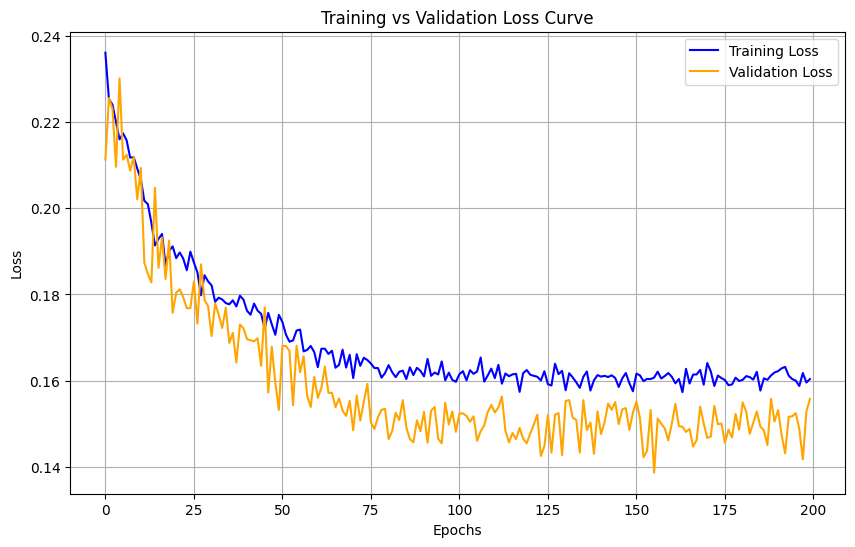

In [ ]:
# Final loss curve after training
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#------------------------------------------------------------------------
#            Testing
#------------------------------------------------------------------------

print("Testing and evaluating...\n")
# Testing loop with unseen test data

# Open a text file to save the outputs
output_file = 'test_results.txt'

# Initialize your metrics and model evaluation
model.eval()
test_loss_metric.reset()
accuracy_metric.reset()
f1_score_metric.reset()
precision_metric.reset()
recall_metric.reset()


# Testing loop with unseen test data
with torch.no_grad():
  for embedding1, embedding2, label in test_loader:
    embedding1, embedding2, label = embedding1.to(device), embedding2.to(device), label.to(device)
    # Model prediction
    similarity = model(embedding1, embedding2)  # Get similarity score
    loss = criterion(similarity, label)
    test_loss_metric.update(loss.item())

    # Dynamic thresholding for binary classification
    batch_similarity = similarity  # Assuming similarity is a tensor
    dynamic_predictions = dynamic_cosine_threshold(similarity, batch_similarity)


    accuracy_metric.update(dynamic_predictions, label)
    f1_score_metric.update(dynamic_predictions, label)
    precision_metric.update(dynamic_predictions, label)
    recall_metric.update(dynamic_predictions, label)

test_loss = test_loss_metric.compute()
accuracy = accuracy_metric.compute()
f1_score = f1_score_metric.compute()
precision = precision_metric.compute()
recall = recall_metric.compute()

# Print and save metrics
with open(output_file, 'a') as f:  # Append mode for metrics
    f.write("\nMetrics:\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1_score:.4f}\n")

# Print results to console
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Test results saved to {output_file}")


Testing and evaluating...

Test Loss: 0.1514
Accuracy: 0.7275
Precision: 0.6766
Recall: 0.8717
F1 Score: 0.7618
Test results saved to test_results.txt


<Figure size 500x400 with 0 Axes>

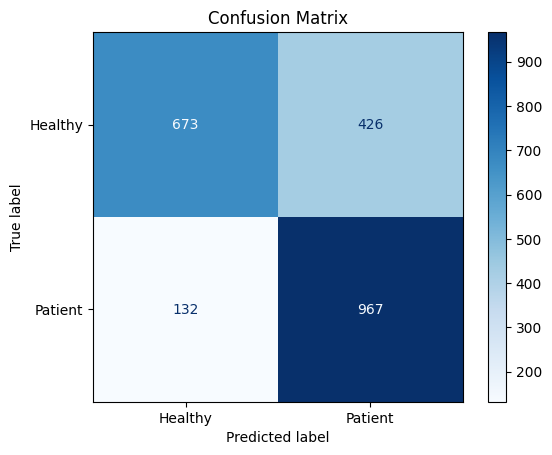

In [ ]:
# Generate confusion matrix
true_labels = []
predicted_labels = []

for embedding1, embedding2, label in test_loader:
    embedding1, embedding2, label = embedding1.to(device), embedding2.to(device), label.to(device)
    similarity = model(embedding1, embedding2)
    predictions = dynamic_cosine_threshold(similarity, similarity.mean())
    true_labels.extend(label.cpu().numpy())
    predicted_labels.extend(predictions.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Patient'])

# Plot confusion matrix
plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

